### <ins>__T√©rminos clave:__</ins>


* <ins>__An√°lisis de cohortes__</ins> se refiere a la pr√°ctica de agrupar usuarios bas√°ndose en caracter√≠sticas compartidas para un an√°lisis en profundidad. En este caso, cada cohorte representa a los clientes agrupados por su a√±o de registro.

* <ins>__La tasa de cancelaci√≥n (churn rate)__</ins>  se calcula como el n√∫mero de clientes que dejaron de realizar transacciones, dividido por el n√∫mero total de clientes en ese mismo per√≠odo de tiempo.

* <ins>__Se considera que un cliente ha cancelado (churned)__</ins> si ha tenido 100 d√≠as de inactividad de compra, bas√°ndose en la Fecha del √öltimo Inicio de Sesi√≥n.

__Los clientes activos son aquellos que no han cancelado bajo esa definici√≥n.__

<ins>__Utilice el 31 de diciembre de 2022 como fecha de referencia para su an√°lisis.__</ins>

La antig√ºedad de un cliente debe calcularse como el tiempo entre su primera y su √∫ltima compra.

El per√≠odo de <ins>__pre-compra__</ins> se define como el tiempo entre la fecha de registro del cliente y su primer pedido.

Los clientes que utilizaron cr√©dito para reservas son aquellos con un Monto de Cr√©dito (Credit Amount) diferente a 0.

### <ins>__Plan de acci√≥n:__</ins>

1. __Unificar y Limpiar Datos__: Juntaremos compras y devoluciones. Convertiremos las fechas y filtraremos todo seg√∫n la fecha de referencia: 31 de diciembre de 2022.

2. __Crear Perfil por Cliente__: Agruparemos todos los datos por Member ID para tener una √∫nica fila por cliente con su informaci√≥n clave (primera/√∫ltima compra, √∫ltimo login, etc.).

3. __Calcular las Nuevas M√©tricas__: Crearemos columnas extra:

__IsChurned__: Un indicador (S√≠/No) basado en los 100 d√≠as de inactividad.

__CustomerTenure__: Antig√ºedad del cliente.

__PrePurchasePeriod__: Tiempo que tard√≥ en hacer la primera compra.

__UsedCredit__: Un indicador (S√≠/No) si us√≥ cr√©dito.

Para realizar y presentar el An√°lisis: vamos a calcular la tasa de cancelaci√≥n general y la compararemos entre distintos segmentos (usuarios de cr√©dito vs. no, cohortes de registro, etc.).

In [1]:
## Importamos librer√≠as
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import os
import datetime
import missingno as msno 

In [5]:
# --- Carga y Preparaci√≥n de Datos ---
# Cargar los archivos CSV en DataFrames
purchases_df = pd.read_csv("../Data/2025-07 purchases_challenge.csv")
refunds_df = pd.read_csv("../Data/2025-07 refunds_challenge.csv")

/var/folders/5w/lt_v_3kd3lnfmfqtkk8r9hjm0000gn/T/ipykernel_8609/228041537.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  purchases_df = pd.read_csv("../Data/2025-07 purchases_challenge.csv")


In [6]:
# Definimos la fecha de referencia para todo el an√°lisis

REFERENCE_DATE = pd.to_datetime('2022-12-31')

In [7]:
## Hay que modificar las columnas "Signup Date", "Last Login Date", "First Order Date" y "Last Order Date"
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197639 entries, 0 to 197638
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Member ID         197639 non-null  int64  
 1   Signup Date       197639 non-null  object 
 2   Last Login Date   195622 non-null  object 
 3   Purchases         197639 non-null  int64  
 4   Total Amount      197639 non-null  float64
 5   Credit Amount     74379 non-null   float64
 6   First Order Date  197639 non-null  object 
 7   Last Order Date   197639 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 12.1+ MB


In [8]:
## Hay que modificar las columnas "Signup Date", "Last Login Date", "First Order Date" y "Last Order Date"
refunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55467 entries, 0 to 55466
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Member ID         55467 non-null  int64  
 1   Signup Date       55467 non-null  object 
 2   Last Login Date   55268 non-null  object 
 3   Refunds           55467 non-null  int64  
 4   Total Amount      55467 non-null  float64
 5   Credit Amount     12485 non-null  float64
 6   First Order Date  55467 non-null  object 
 7   Last Order Date   55467 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.4+ MB


In [9]:
## convertimos todas las columnas de fecha, manejando errores
date_columns = ['Signup Date', 'Last Login Date', 'First Order Date', 'Last Order Date']
for col in date_columns:
    purchases_df[col] = pd.to_datetime(purchases_df[col], errors = 'coerce')
for col in date_columns:
    refunds_df[col] = pd.to_datetime(refunds_df[col], errors = 'coerce')

In [10]:
## Chequeo que se hayan modificado los tipos de datos de las columnas
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197639 entries, 0 to 197638
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Member ID         197639 non-null  int64         
 1   Signup Date       197639 non-null  datetime64[ns]
 2   Last Login Date   195622 non-null  datetime64[ns]
 3   Purchases         197639 non-null  int64         
 4   Total Amount      197639 non-null  float64       
 5   Credit Amount     74379 non-null   float64       
 6   First Order Date  197639 non-null  datetime64[ns]
 7   Last Order Date   197639 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 12.1 MB


In [11]:
refunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55467 entries, 0 to 55466
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Member ID         55467 non-null  int64         
 1   Signup Date       55467 non-null  datetime64[ns]
 2   Last Login Date   55268 non-null  datetime64[ns]
 3   Refunds           55467 non-null  int64         
 4   Total Amount      55467 non-null  float64       
 5   Credit Amount     12485 non-null  float64       
 6   First Order Date  55467 non-null  datetime64[ns]
 7   Last Order Date   55467 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 3.4 MB


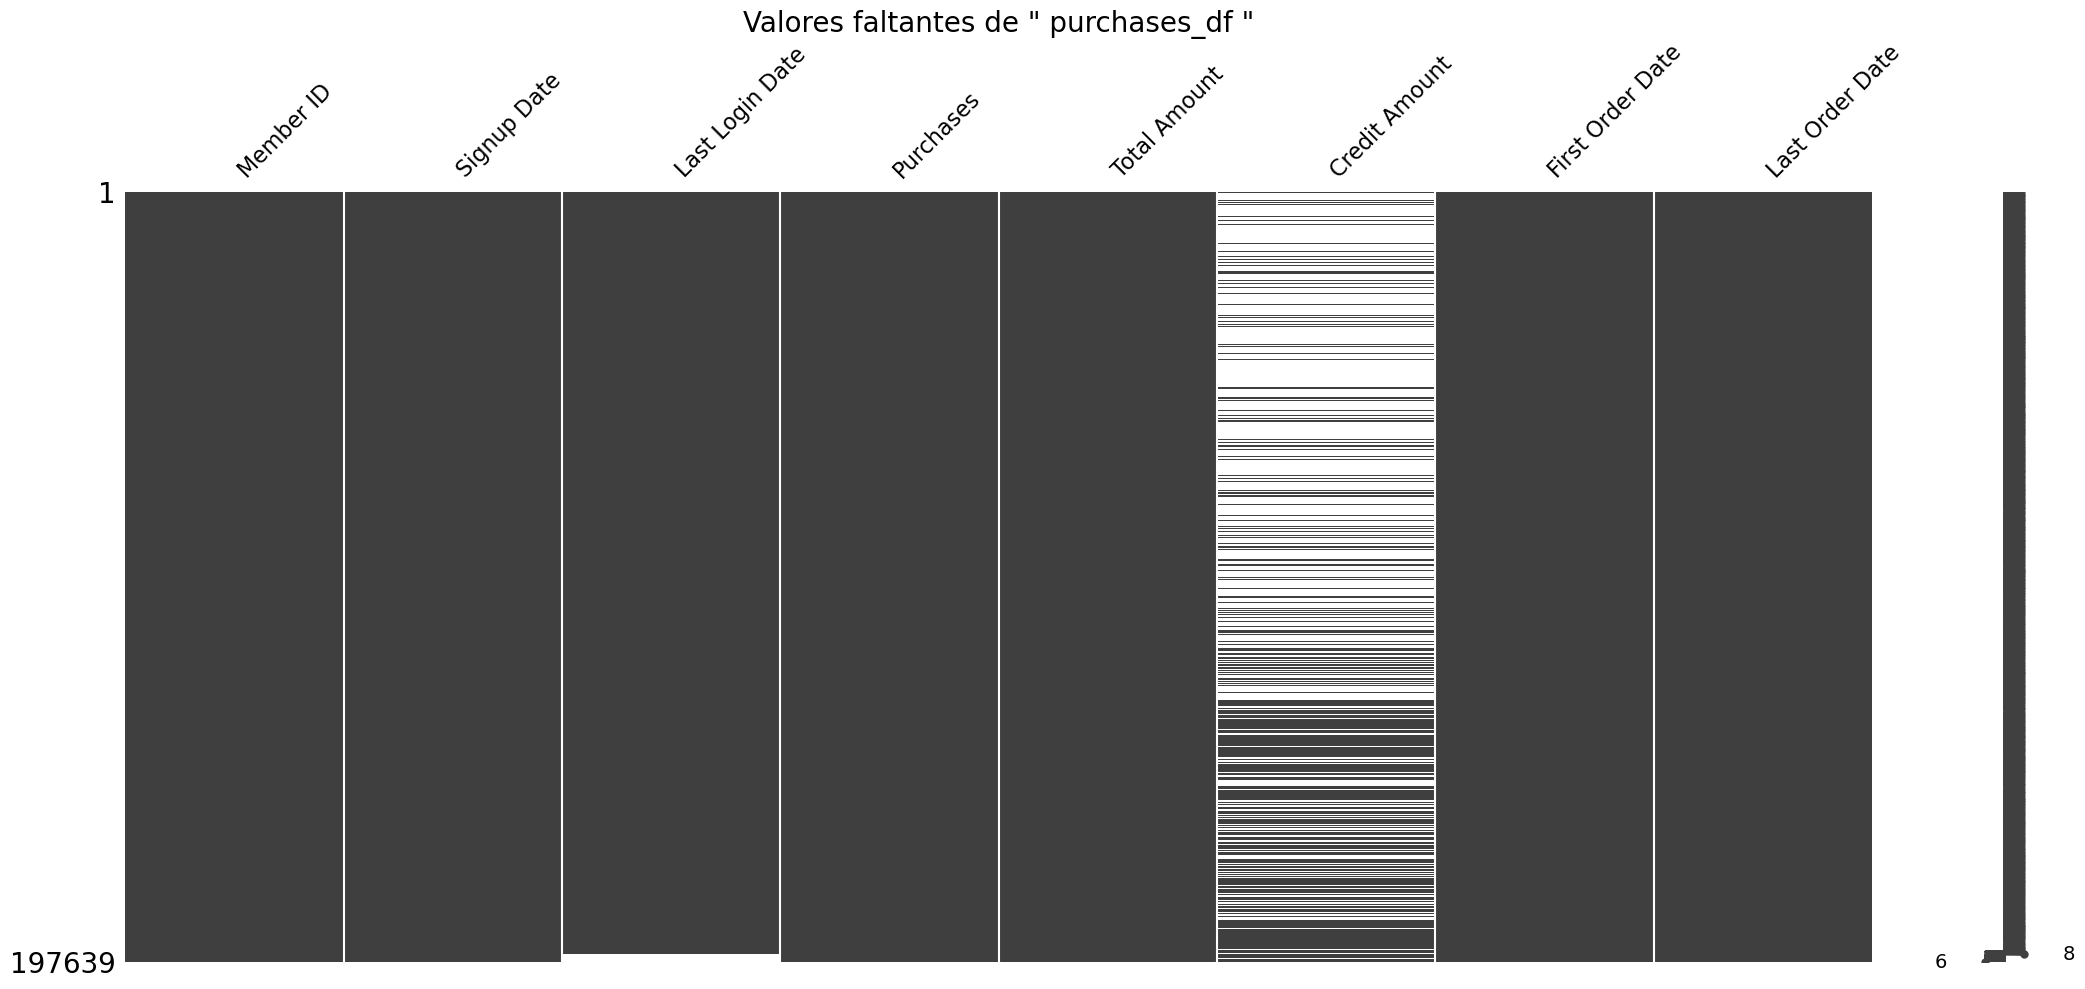

In [12]:
## Chequeo si hay valores faltantes en las columnas de ambos datasets
msno.matrix(purchases_df)
plt.title('Valores faltantes de " purchases_df "', fontsize = 20)
plt.show()

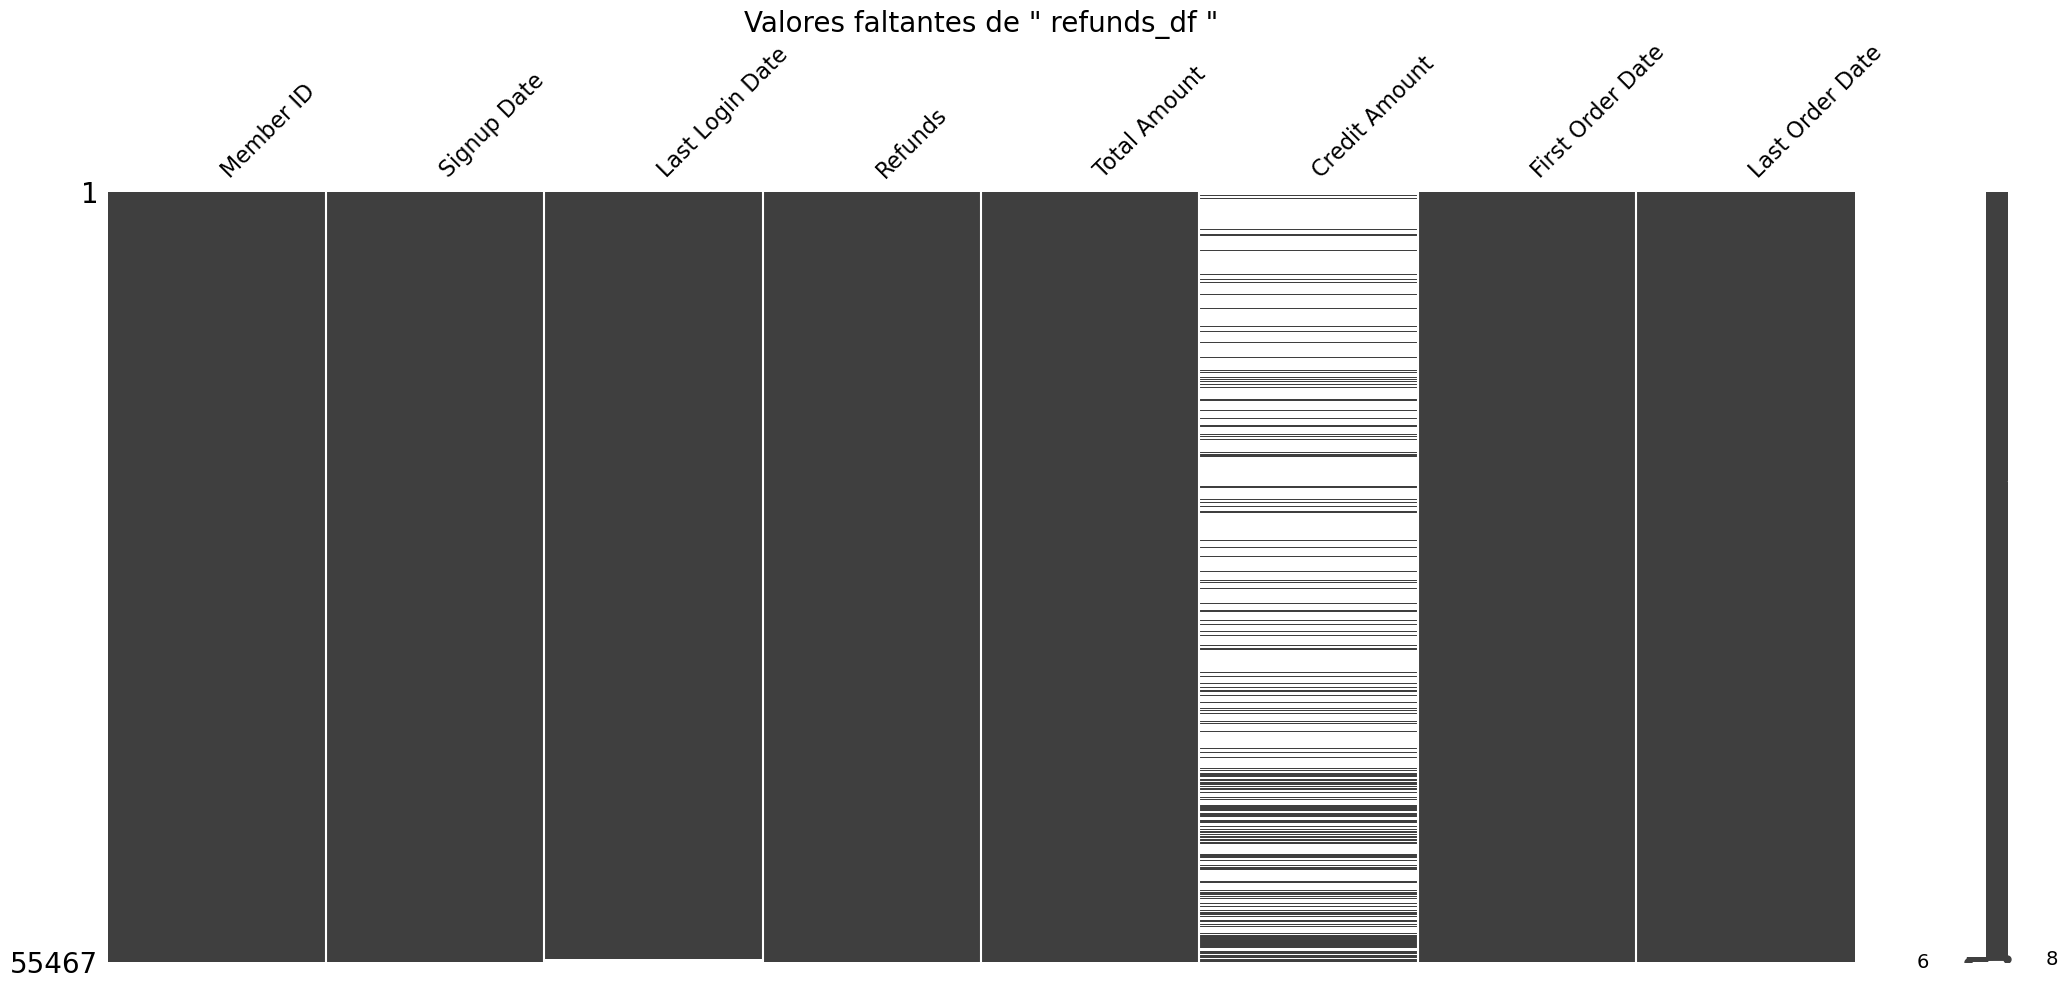

In [13]:
## Chequeo si hay valores faltantes en las columnas de ambos datasets
msno.matrix(refunds_df)
plt.title('Valores faltantes de " refunds_df "', fontsize = 20)
plt.show()

In [14]:
## Unimos todo en un solo dataframe 
## Usamos concat para tener un dataframe apilado arriba del otro, con el fin de mantener todos los detalles de todas las filas.

concatenado = pd.concat([purchases_df, refunds_df], ignore_index = True)

In [15]:
"Guardamos el dataframe creado"
#concatenado.to_csv('concatenado.csv', index=False)

'Guardamos el dataframe creado'

In [16]:
## Filtramos los datos para que todo sea anterior a la fecha de referencia
concatenado = concatenado[concatenado['Signup Date'] < REFERENCE_DATE]

In [17]:
## Eliminamos filas donde las fechas clave son nulas (ya sabemos de antemano que no hay valores faltantes en estas columnas)
concatenado.dropna(subset=['Signup Date', 'Last Login Date', 'First Order Date', 'Last Order Date'], inplace=True)

In [53]:
# --- Crear Perfil por Cliente (Agregaci√≥n) ---

# Agrupamos por cliente para obtener una vista √∫nica
customer_df = concatenado.groupby('Member ID').agg(
        SignupDate=('Signup Date', 'first'),
        LastLoginDate=('Last Login Date', 'max'),
        FirstOrderDate=('First Order Date', 'min'),
        LastOrderDate=('Last Order Date', 'max'),
        TotalSpend=('Total Amount', 'sum'),
        # Ahora sumamos la columna 'Purchases' para obtener el conteo correcto de pedidos
        PurchaseOrders=('Purchases', 'sum'),
        CreditAmountSum=('Credit Amount', 'sum')
    ).reset_index()


    # Convertimos a entero
customer_df['PurchaseOrders'] = customer_df['PurchaseOrders'].astype(int)


In [54]:
customer_df

Member ID SignupDate LastLoginDate FirstOrderDate LastOrderDate  \
0          289584 2015-01-01    2021-01-22     2016-12-18    2016-12-18   
1          289586 2015-01-01    2020-06-14     2020-01-30    2020-01-30   
2          289592 2015-01-01    2023-05-01     2018-12-08    2018-12-08   
3          289599 2015-01-01    2023-05-29     2019-01-29    2019-11-08   
4          289616 2015-01-01    2023-05-10     2020-12-17    2023-03-27   
...           ...        ...           ...            ...           ...   
187934    1705017 2022-12-30    2023-06-01     2023-01-15    2023-05-27   
187935    1705024 2022-12-30    2023-04-23     2023-03-18    2023-03-18   
187936    1705050 2022-12-30    2023-05-30     2023-01-23    2023-05-03   
187937    1705086 2022-12-30    2023-05-31     2023-04-29    2023-04-29   
187938    1705113 2022-12-30    2023-05-31     2023-01-04    2023-01-28   

        TotalSpend  PurchaseOrders  CreditAmountSum  
0           401.51               1              0.0  
1            89.48               1              0.0  
2           128.03               1              0.0  
3           645.04               4              0.0  
4          2125.65               4              0.0  
...            ...             ...              ...  
187934     1798.97               5            -35.0  
187935      130.33               1            -10.0  
187936      219.07               2              0.0  
187937      965.08               1              0.0  
187938      297.36               2            -10.0  

[187939 rows x 8 columns]

In [76]:
## Unimos los conteos de pedidos al perfil del cliente>
#customer_df = customer_df.merge(purchase_orders, on='Member ID', how='left').fillna({'PurchaseOrders': 0})
#customer_df = customer_df.merge(refund_orders, on='Member ID', how='left').fillna({'RefundOrders': 0})

In [55]:
# --- Calcular las Nuevas M√©tricas ---

# 1. Indicador de Cancelaci√≥n (Churn)
days_since_last_login = (REFERENCE_DATE - customer_df['LastLoginDate']).dt.days
customer_df['IsChurned'] = days_since_last_login > 100

# 2. Antig√ºedad del Cliente (Tenure)
customer_df['CustomerTenureDays'] = (customer_df['LastOrderDate'] - customer_df['FirstOrderDate']).dt.days
    
# Filtramos antig√ºedades negativas por si hay errores de datos
customer_df = customer_df[customer_df['CustomerTenureDays'] >= 0]
    
# 3. Per√≠odo de Pre-Compra
customer_df['PrePurchasePeriodDays'] = (customer_df['FirstOrderDate'] - customer_df['SignupDate']).dt.days
customer_df = customer_df[customer_df['PrePurchasePeriodDays'] >= 0]
    
# 4. Uso de Cr√©dito
customer_df['UsedCredit'] = customer_df['CreditAmountSum'].notna() & (customer_df['CreditAmountSum'] != 0)

In [56]:
# --- Realizar y Presentar el An√°lisis ---
    
print(f"--- üìä An√°lisis de Cancelaci√≥n (Churn) al {REFERENCE_DATE.date()} ---")

# Tasa de cancelaci√≥n general

total_customers = len(customer_df) ## Se calcula el total de clientes
churned_customers = customer_df['IsChurned'].sum()
churn_rate_total = (churned_customers / total_customers) * 100
print(f"\n1. Tasa de Cancelaci√≥n General: {churn_rate_total:.2f}% ({churned_customers} de {total_customers} clientes)")

--- üìä An√°lisis de Cancelaci√≥n (Churn) al 2022-12-31 ---

1. Tasa de Cancelaci√≥n General: 38.16% (71723 de 187939 clientes)


In [57]:
# An√°lisis por uso de cr√©dito
print(f"--- üìä An√°lisis de Cancelaci√≥n (Churn) al {REFERENCE_DATE.date()} ---")
churn_by_credit = customer_df.groupby('UsedCredit')['IsChurned'].mean() * 100
print("\n2. Tasa de Cancelaci√≥n por Uso de Cr√©dito:")
print(f"   - Clientes que USARON cr√©dito: {churn_by_credit[True]:.2f}%")
print(f"   - Clientes que NO usaron cr√©dito: {churn_by_credit[False]:.2f}%")    

--- üìä An√°lisis de Cancelaci√≥n (Churn) al 2022-12-31 ---

2. Tasa de Cancelaci√≥n por Uso de Cr√©dito:
   - Clientes que USARON cr√©dito: 22.19%
   - Clientes que NO usaron cr√©dito: 46.91%


In [58]:
print(f"--- üìä An√°lisis de Cancelaci√≥n (Churn) al {REFERENCE_DATE.date()} ---")
# An√°lisis de caracter√≠sticas de clientes cancelados vs. activos
print("\n3. Comparaci√≥n entre Clientes Activos y Cancelados (Promedios):")
comparison = customer_df.groupby('IsChurned')[['CustomerTenureDays', 'PrePurchasePeriodDays', 'TotalSpend']].mean()
print(comparison.round(2))


--- üìä An√°lisis de Cancelaci√≥n (Churn) al 2022-12-31 ---

3. Comparaci√≥n entre Clientes Activos y Cancelados (Promedios):
           CustomerTenureDays  PrePurchasePeriodDays  TotalSpend
IsChurned                                                       
False                  588.66                 436.37     1614.07
True                   222.36                 292.26      697.81


In [59]:
print(f"--- üìä An√°lisis de Cancelaci√≥n (Churn) al {REFERENCE_DATE.date()} ---")
# An√°lisis de churn por a√±o de registro
customer_df['SignupYear'] = customer_df['SignupDate'].dt.year
churn_by_signup_year = customer_df.groupby('SignupYear')['IsChurned'].mean() * 100
print("\n4. Tasa de Cancelaci√≥n por A√±o de Registro (Cohorte):")
print(churn_by_signup_year.round(2).to_string())

--- üìä An√°lisis de Cancelaci√≥n (Churn) al 2022-12-31 ---

4. Tasa de Cancelaci√≥n por A√±o de Registro (Cohorte):
SignupYear
2015    44.34
2016    44.38
2017    46.67
2018    43.68
2019    41.87
2020    42.45
2021    37.31
2022    13.67


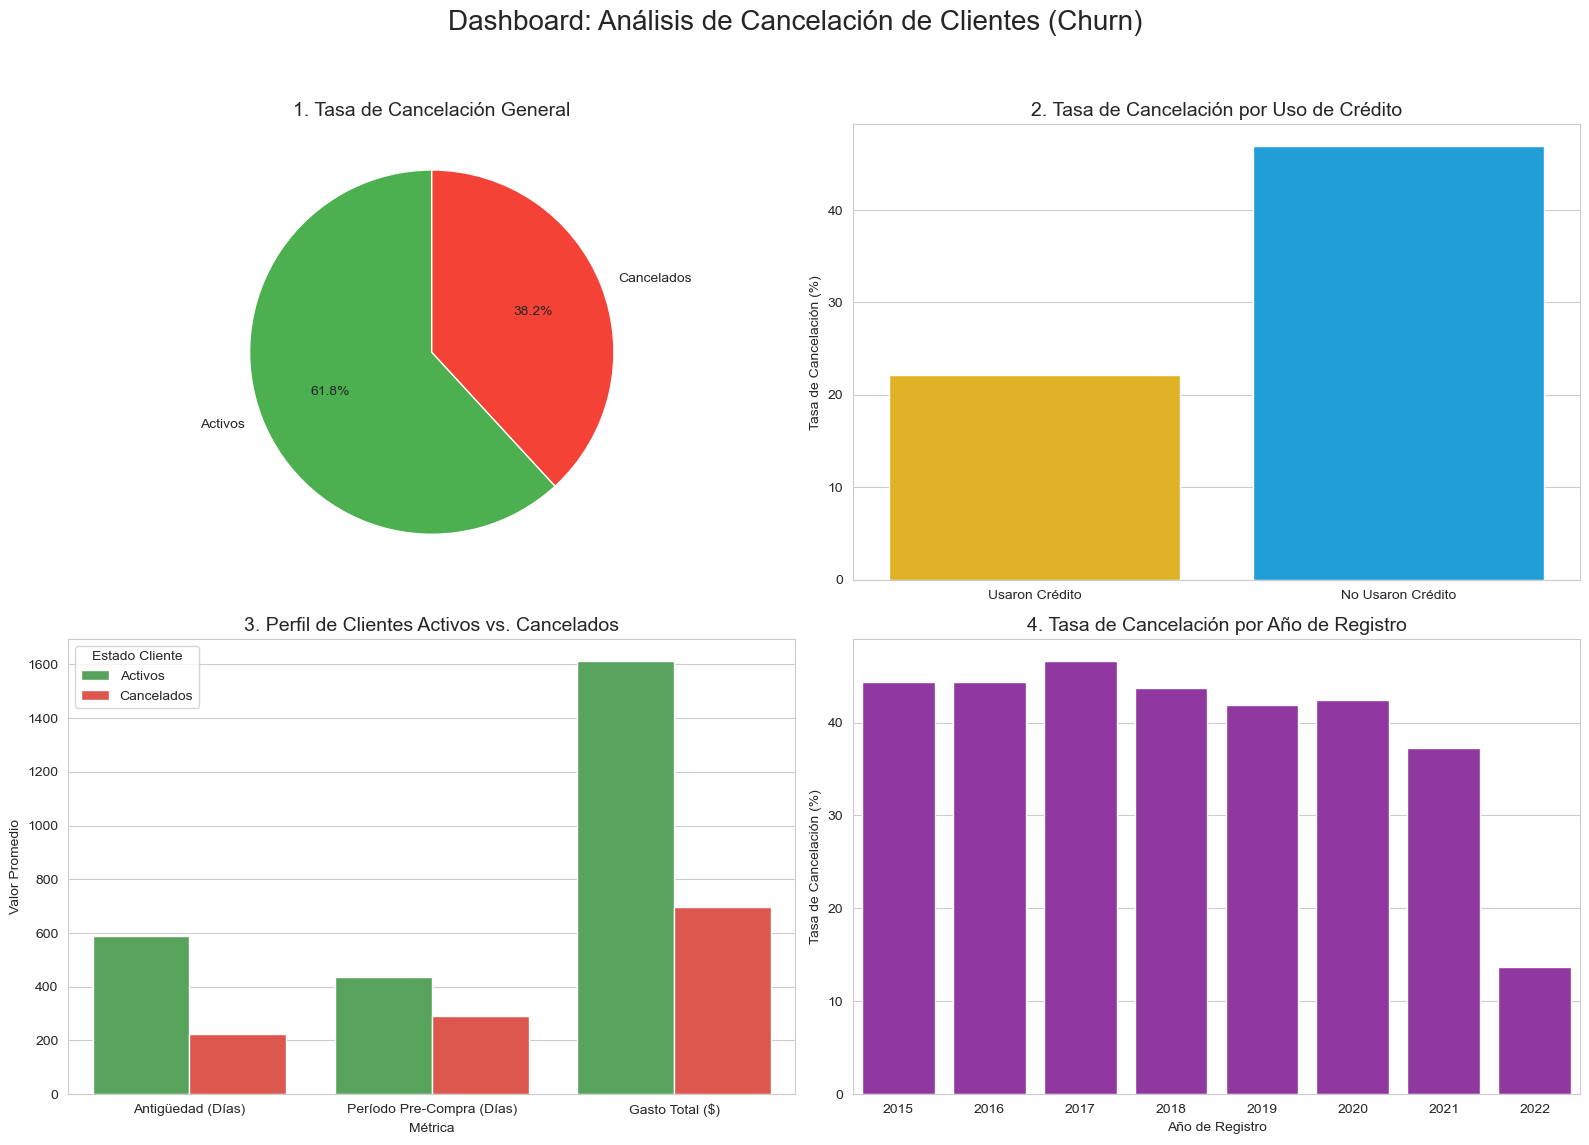

In [60]:
# --- Preparamos los datos del resumen para graficar ---

# 1. Datos para Tasa de Cancelaci√≥n General
churn_general_data = {
    'Categor√≠a': ['Activos', 'Cancelados'],
    'Porcentaje': [100 - 38.16, 38.16]
}
# 2. Datos para Tasa de Cancelaci√≥n por Uso de Cr√©dito
churn_credit_data = {
    'Categor√≠a': ['Usaron Cr√©dito', 'No Usaron Cr√©dito'],
    'Tasa de Cancelaci√≥n (%)': [22.19, 46.91]
}
df_churn_credit = pd.DataFrame(churn_credit_data)
# 3. Datos para Comparaci√≥n de Clientes
comparison_data = {
    'M√©trica': ['Antig√ºedad (D√≠as)', 'Per√≠odo Pre-Compra (D√≠as)', 'Gasto Total ($)'],
    'Activos': [588.66, 436.37, 1614.07],
    'Cancelados': [222.36, 292.26, 697.81]
}
df_comparison = pd.melt(pd.DataFrame(comparison_data), id_vars=['M√©trica'], var_name='Estado Cliente', value_name='Valor')
# 4. Datos para Tasa de Cancelaci√≥n por A√±o
churn_year_data = {
    'A√±o de Registro': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'Tasa de Cancelaci√≥n (%)': [44.34, 44.38, 46.67, 43.68, 41.87, 42.45, 37.31, 13.67]
}
df_churn_year = pd.DataFrame(churn_year_data)

# --- Generamos los 4 Gr√°ficos ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard: An√°lisis de Cancelaci√≥n de Clientes (Churn)', fontsize=20)

# Gr√°fico 1: Tasa de Cancelaci√≥n General
axes[0, 0].pie(churn_general_data['Porcentaje'], labels=churn_general_data['Categor√≠a'], autopct='%1.1f%%',
               startangle=90, colors=['#4CAF50', '#F44336'])
axes[0, 0].set_title('1. Tasa de Cancelaci√≥n General', fontsize=14)

# Gr√°fico 2: Tasa de Cancelaci√≥n por Uso de Cr√©dito
sns.barplot(
    ax=axes[0, 1], 
    x='Categor√≠a', 
    y='Tasa de Cancelaci√≥n (%)', 
    data=df_churn_credit, 
    palette=['#FFC107', '#03A9F4'],
    hue='Categor√≠a',  # A√±adimos 'hue'
    legend=False      # Ocultamos la leyenda que se genera autom√°ticamente
)
axes[0, 1].set_title('2. Tasa de Cancelaci√≥n por Uso de Cr√©dito', fontsize=14)
axes[0, 1].set_ylabel('Tasa de Cancelaci√≥n (%)')
axes[0, 1].set_xlabel('')

# Gr√°fico 3: Comparaci√≥n entre Clientes Activos y Cancelados
sns.barplot(ax=axes[1, 0], x='M√©trica', y='Valor', hue='Estado Cliente', data=df_comparison, palette=['#4CAF50', '#F44336'])
axes[1, 0].set_title('3. Perfil de Clientes Activos vs. Cancelados', fontsize=14)
axes[1, 0].set_xlabel('M√©trica')
axes[1, 0].set_ylabel('Valor Promedio')

# Gr√°fico 4: Tasa de Cancelaci√≥n por A√±o de Registro
sns.barplot(ax=axes[1, 1], x='A√±o de Registro', y='Tasa de Cancelaci√≥n (%)', data=df_churn_year, color='#9C27B0')
axes[1, 1].set_title('4. Tasa de Cancelaci√≥n por A√±o de Registro', fontsize=14)
axes[1, 1].set_ylabel('Tasa de Cancelaci√≥n (%)')
axes[1, 1].set_xlabel('A√±o de Registro')

# Ajustamos y mostramos el dashboard
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [61]:
## Este es el dataframe creado con las nuevas columnas adicionales y agrupado por Member ID
#customer_df.to_csv('customer_df.csv', index=False)
#customer_df.head()

Member ID SignupDate LastLoginDate FirstOrderDate LastOrderDate  \
0     289584 2015-01-01    2021-01-22     2016-12-18    2016-12-18   
1     289586 2015-01-01    2020-06-14     2020-01-30    2020-01-30   
2     289592 2015-01-01    2023-05-01     2018-12-08    2018-12-08   
3     289599 2015-01-01    2023-05-29     2019-01-29    2019-11-08   
4     289616 2015-01-01    2023-05-10     2020-12-17    2023-03-27   

   TotalSpend  PurchaseOrders  CreditAmountSum  IsChurned  CustomerTenureDays  \
0      401.51               1              0.0       True                   0   
1       89.48               1              0.0       True                   0   
2      128.03               1              0.0      False                   0   
3      645.04               4              0.0      False                 283   
4     2125.65               4              0.0      False                 830   

   PrePurchasePeriodDays  UsedCredit  SignupYear  
0                    717       False        2015  
1                   1855       False        2015  
2                   1437       False        2015  
3                   1489       False        2015  
4                   2177       False        2015

### --- C√°lculo y Presentaci√≥n de las 10 M√©tricas Solicitadas ---

In [62]:
print(f"--- üìã M√©tricas Clave al {REFERENCE_DATE.date()} ---")

    # 1. Per√≠odo m√≠nimo de pre-compra
min_prepurchase = customer_df['PrePurchasePeriodDays'].min()
print(f"\n1. Per√≠odo M√çNIMO de pre-compra: {min_prepurchase} d√≠as")

--- üìã M√©tricas Clave al 2022-12-31 ---

1. Per√≠odo M√çNIMO de pre-compra: 0 d√≠as


In [63]:
    # 2. Per√≠odo m√°ximo de pre-compra
max_prepurchase = customer_df['PrePurchasePeriodDays'].max()
print(f"2. Per√≠odo M√ÅXIMO de pre-compra: {max_prepurchase} d√≠as")

2. Per√≠odo M√ÅXIMO de pre-compra: 3059 d√≠as


In [64]:
# Agrupamos por estado de churn para las siguientes m√©tricas
grouped_by_churn = customer_df.groupby('IsChurned')

In [65]:
    # 3. Antig√ºedad promedio de los clientes activos
avg_tenure_active = grouped_by_churn['CustomerTenureDays'].mean()[False]
print(f"\n3. Antig√ºedad promedio de clientes ACTIVOS: {avg_tenure_active:.2f} d√≠as")


3. Antig√ºedad promedio de clientes ACTIVOS: 588.66 d√≠as


In [66]:
    # 4. Antig√ºedad promedio de los clientes cancelados
avg_tenure_churned = grouped_by_churn['CustomerTenureDays'].mean()[True]
print(f"4. Antig√ºedad promedio de clientes CANCELADOS: {avg_tenure_churned:.2f} d√≠as")

4. Antig√ºedad promedio de clientes CANCELADOS: 222.36 d√≠as


In [67]:
purchase_orders = concatenado[concatenado['Total Amount'] > 0].groupby('Member ID').size().rename('PurchaseOrders')
customer_df['PurchaseOrders'] = customer_df['PurchaseOrders'].astype(int)

In [68]:
    # 5. N√∫mero promedio de pedidos realizados por clientes cancelados
avg_orders_churned = grouped_by_churn['PurchaseOrders'].mean()[True]
print(f"\n5. N√∫mero promedio de pedidos de clientes CANCELADOS: {avg_orders_churned:.2f}")


5. N√∫mero promedio de pedidos de clientes CANCELADOS: 3.02


In [69]:
    # 6. N√∫mero promedio de pedidos realizados por clientes activos
avg_orders_active = grouped_by_churn['PurchaseOrders'].mean()[False]
print(f"6. N√∫mero promedio de pedidos de clientes ACTIVOS: {avg_orders_active:.2f}")


6. N√∫mero promedio de pedidos de clientes ACTIVOS: 6.02


In [70]:
    # 7. Monto promedio gastado por clientes cancelados
avg_spend_churned = grouped_by_churn['TotalSpend'].mean()[True]
print(f"\n7. Gasto neto promedio de clientes CANCELADOS: ${avg_spend_churned:.2f}")



7. Gasto neto promedio de clientes CANCELADOS: $697.81


In [71]:
    # 8. Monto promedio gastado por clientes activos
avg_spend_active = grouped_by_churn['TotalSpend'].mean()[False]
print(f"8. Gasto neto promedio de clientes ACTIVOS: ${avg_spend_active:.2f}")


8. Gasto neto promedio de clientes ACTIVOS: $1614.07


In [72]:
    # 9. Tasa de reembolso basada en el n√∫mero de pedidos
total_purchase_orders = concatenado[concatenado['Total Amount'] > 0].shape[0]
total_refund_orders = concatenado[concatenado['Total Amount'] < 0].shape[0]
refund_rate_by_orders = (total_refund_orders / total_purchase_orders) * 100
print(f"\n9. Tasa de reembolso por N√öMERO de pedidos: {refund_rate_by_orders:.2f}%")


9. Tasa de reembolso por N√öMERO de pedidos: 28.41%


In [73]:
        # 10. Tasa de reembolso basada en el monto gastado
total_purchase_amount = concatenado[concatenado['Total Amount'] > 0]['Total Amount'].sum()
total_refund_amount = abs(concatenado[concatenado['Total Amount'] < 0]['Total Amount'].sum())
refund_rate_by_amount = (total_refund_amount / total_purchase_amount) * 100
print(f"10. Tasa de reembolso por MONTO gastado: {refund_rate_by_amount:.2f}%")

10. Tasa de reembolso por MONTO gastado: 18.13%


### Averiguando un poco m√°s:

In [77]:

# Calcular el per√≠odo de pre-compra en d√≠as
customer_df['PrePurchasePeriodDays'] = (customer_df['FirstOrderDate'] - customer_df['SignupDate']).dt.days

# Filtrar resultados il√≥gicos
customer_df = customer_df[customer_df['PrePurchasePeriodDays'] >= 0]

# Calcular las tres estad√≠sticas
promedio = customer_df['PrePurchasePeriodDays'].mean()
mediana = customer_df['PrePurchasePeriodDays'].median()
moda = customer_df['PrePurchasePeriodDays'].mode()[0]  # .mode() puede devolver varios valores, tomamos el primero

print("--- üìä Estad√≠sticas del Per√≠odo de Pre-Compra ---")
print(f"Promedio: {promedio:.2f} d√≠as")
print(f"Mediana: {mediana:.0f} d√≠as")
print(f"Moda (valor m√°s com√∫n): {moda:.0f} d√≠as")

--- üìä Estad√≠sticas del Per√≠odo de Pre-Compra ---
Promedio: 381.37 d√≠as
Mediana: 151 d√≠as
Moda (valor m√°s com√∫n): 1 d√≠as


### __Qu√© Muestra el Gr√°fico?__

El histograma (las barras) te mostrar√° que una gran cantidad de clientes compra en los primeros d√≠as despu√©s de registrarse.

Las l√≠neas verticales te permitir√°n ver visualmente d√≥nde se ubican tus estad√≠sticas clave. Notar√°s que la l√≠nea del promedio (roja) probablemente est√© m√°s a la derecha que la mediana (verde), porque el promedio es "arrastrado" por esos pocos clientes que tardan mucho tiempo en hacer su primera compra.
"""

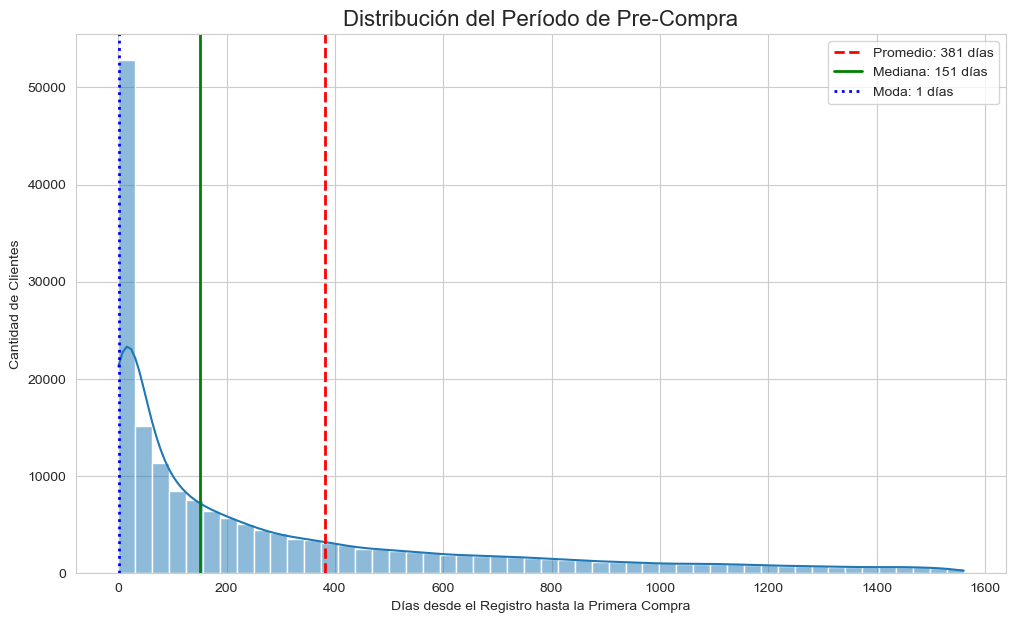

In [78]:

# --- Creaci√≥n del Gr√°fico ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Crear el histograma
# Filtramos para una mejor visualizaci√≥n, excluyendo valores muy extremos si los hubiera
sns.histplot(data=customer_df[customer_df['PrePurchasePeriodDays'] < customer_df['PrePurchasePeriodDays'].quantile(0.95)], 
             x='PrePurchasePeriodDays', 
             bins=50, 
             kde=True)

# A√±adir las l√≠neas verticales para las estad√≠sticas
plt.axvline(promedio, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio:.0f} d√≠as')
plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.0f} d√≠as')
plt.axvline(moda, color='blue', linestyle=':', linewidth=2, label=f'Moda: {moda:.0f} d√≠as')

# T√≠tulos y leyenda
plt.title('Distribuci√≥n del Per√≠odo de Pre-Compra', fontsize=16)
plt.xlabel('D√≠as desde el Registro hasta la Primera Compra')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.show()

## An√°lisis Detallado

La Moda (1 d√≠a) es la Historia de √âxito: El pico masivo del gr√°fico al principio (la moda) indica que el comportamiento m√°s com√∫n es que un cliente se registre y compre casi de inmediato (en 1 d√≠a). Esto es excelente y sugiere que tienes un gran grupo de usuarios con alta intenci√≥n de compra que llegan a la plataforma listos para reservar.

La Mediana (151 d√≠as) revela la Gran Oportunidad: Este es el dato clave. La mediana nos dice que el 50% de tus clientes tarda hasta 5 meses en hacer su primera compra. Esto dibuja un segundo perfil de cliente: el "planificador" o el "curioso". Se registran, pero no tienen una necesidad inmediata y esperan el momento o la oferta adecuada.

El Promedio (381 d√≠as) est√° Sesgado: El promedio es mucho m√°s alto que la mediana. Esto confirma que la distribuci√≥n est√° fuertemente sesgada a la derecha, lo que significa que unos pocos clientes que tardan much√≠simo tiempo en comprar (outliers) est√°n "inflando" el promedio. Para entender al cliente t√≠pico, la mediana (151 d√≠as) es una m√©trica mucho m√°s confiable que el promedio.

## Conclusiones Estrat√©gicas

El gr√°fico te dice que no tienes un tipo de cliente, sino dos muy diferentes a los que puedes dirigirte con estrategias distintas:

Para los Compradores Inmediatos (la Moda): El proceso desde que descubren una oferta hasta que finalizan la reserva debe ser impecable, r√°pido y sin fricci√≥n. Cualquier obst√°culo puede hacer que pierdas estas conversiones de alto valor.

Para los Planificadores (la Mediana y la cola larga): Aqu√≠ est√° la mayor √°rea de oportunidad para ID90. Si logras reducir la mediana de 151 d√≠as, acelerar√°s tus ingresos de manera significativa.

Acci√≥n Recomendada: Implementar una campa√±a de onboarding por correo electr√≥nico. Cuando un usuario se registra y no compra en los primeros 7-15 d√≠as, se le puede enviar una secuencia de correos para:

Mostrarle c√≥mo sacar el m√°ximo provecho a la plataforma.

Presentarle ofertas personalizadas basadas en su aerol√≠nea o ubicaci√≥n.

Crear un sentido de urgencia con ofertas por tiempo limitado.